# Import Libraries

In [173]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.feature_selection import f_regression

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from statsmodels.stats.outliers_influence import variance_inflation_factor

from lazypredict.Supervised import LazyRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [13]:
pd.set_option('display.float_format', '{:.6f}'.format)

# Clean Data

In [165]:
# Import Data:
Ames_HousePrice = pd.read_csv('Ames_HousePrice.csv', index_col=0)
real_coords = pd.read_csv("real_estate_with_coordinates.csv")

# One row is duplicated in Ames_HousePrice df, once dropped there are no duplicate PID values
Ames_HousePrice = Ames_HousePrice.drop_duplicates()
real_coords = real_coords.drop_duplicates()

# Dataframe merging
real_estate_columns_to_keep = ['GeoRefNo','Prop_Addr', 'MA_Zip1','latitude', 'longitude']
housing_coords = pd.merge(Ames_HousePrice, real_coords[real_estate_columns_to_keep],
                               left_on='PID', right_on='GeoRefNo', how='left')

# Remove any duplicate rows created in merge
housing_coords = housing_coords.drop_duplicates()

# Remove outliers 528351010 has too high sale price, 908154205, has too much area
housing_coords = housing_coords[~housing_coords['PID'].isin([528351010, 908154205])]

# Drop Columns with too many NA Values
# housing_coords.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'],axis=1,inplace=True)

# Update missing gps data rows:
# housing_coords = housing_coords.dropna(subset=['latitude'])
mean_latitude = housing_coords['latitude'].mean()
housing_coords['latitude'].fillna(mean_latitude, inplace=True)

mean_longitude = housing_coords['longitude'].mean()
housing_coords['longitude'].fillna(mean_longitude, inplace=True)

# DistanceToISU column contains the distance of each property to Iowa State University
# Coordinates of Iowa State University
isu_latitude = 42.0239
isu_longitude = -93.6476
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in miles
    radius = 3958.8
    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    # Differences in latitude and longitude
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Calculate the distance
    distance = radius * c
    return distance
# Calculate distance for each property address
housing_coords['DistanceToISU'] = housing_coords.apply(
    lambda row: haversine(row['latitude'], row['longitude'], isu_latitude, isu_longitude), axis=1)

# 2 rows with gps info but missing zip:
specified_addresses = ['2010 KILDEE ST', '1310 WOODSTOCK AVE']
# Update 'Zipcode' to 50014 where 'Address' is in the specified list
housing_coords.loc[housing_coords['Prop_Addr'].isin(specified_addresses), 'MA_Zip1'] = 50014
    
# 'Prop_Addr' column useful for EDA and data cleaning but not for modeling
housing_coords.drop('Prop_Addr',axis=1,inplace=True)

# Reset index after dropping rows so flitering by iloc works smoothly
housing_coords.reset_index(drop=True,inplace=True)

# This is good for EDA but since it is calculated from the target it will cause 
# data leakage and shouldn't be included in modeling
    # # Added PricePerSF Column
    # housing_coords['PricePerSF'] = housing_coords['SalePrice'] / housing_coords['GrLivArea']

# Delete utilities column, it has 2496/2497 with same value
    # housing_coords.Utilities.value_counts() # <-- No N/As here
housing_coords.drop('Utilities',axis=1,inplace=True)

# Fix Row with Missing Values in Basement Categories
housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
    'BsmtFullBath','BsmtHalfBath']] = housing_coords.loc[housing_coords.PID==903230120,[
    'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']].fillna(0)

# Masonry Veneer (Type/Area)
    # If Type = 'None' but Area != 0, Type updated to mode
    # N/As updated to None for Type and 0 for Area
idx = (housing_coords['MasVnrArea'].isna()) & (housing_coords['MasVnrType'].isna())
housing_coords.loc[idx, 'MasVnrArea'] = housing_coords.loc[idx, 'MasVnrArea'].fillna(0)
housing_coords.loc[idx, 'MasVnrType'] = housing_coords.loc[idx, 'MasVnrType'].fillna('None')
mode_MasVnrType = housing_coords.loc[housing_coords.MasVnrType!='None'].MasVnrType.mode()[0]
idx2 = (housing_coords['MasVnrArea']!=0) & (housing_coords['MasVnrType']== 'None')
housing_coords.loc[idx2, 'MasVnrType'] = housing_coords.loc[idx2, 'MasVnrType'].fillna(mode_MasVnrType)

# Fix Row with Missing Values in GarageCars & GarageArea Categories
idx3 = (housing_coords['GarageArea']!=0) & (housing_coords['GarageType']=='Detchd')
mean_GarageArea = round(housing_coords.loc[idx3, 'GarageArea'].mean())
housing_coords.loc[housing_coords.PID==910201180,'GarageArea'] = mean_GarageArea
idx4 = housing_coords['GarageType']=='Detchd'
mode_GarageCars = housing_coords.loc[idx4, 'GarageCars'].mode()[0]
housing_coords.loc[housing_coords.PID==910201180,'GarageCars'] = mode_GarageCars

# Fill GarageYrBlt to match Year House Was Built
housing_coords['GarageYrBlt'] = housing_coords['GarageYrBlt'].fillna(housing_coords['YearBuilt']) # 129 N/A

# Fix Row where Year Remodeled occured before Year Built
housing_coords.loc[housing_coords.PID==907194160,'YearRemodAdd'] = \
housing_coords.loc[housing_coords.PID==907194160,'YearBuilt']

# Fill with Most Common (Categorical) Value:
mode_Electrical = housing_coords['Electrical'].mode()[0] # 1 N/A
housing_coords['Electrical'].fillna(mode_Electrical, inplace=True)

# 451 N/A values for Lot Frontage
    # The average ratio of LotFrontage/LotArea was calculated for each
    # LotType & LotShape and this percentage factor was used to calculate
    # The missing LotFrontage Values (since LotArea was not missing)
lot_df = housing_coords.loc[housing_coords['LotFrontage'].notna()][[
    'LotFrontage','LotArea','LotConfig','LotShape']]
lot_df2 = lot_df.groupby(['LotConfig','LotShape']).agg({'LotFrontage':'mean','LotArea':'mean'})
lot_df2['PCT_Frontage']=lot_df2['LotFrontage']/lot_df2['LotArea']
percentage_factor_mapping = lot_df2['PCT_Frontage'].to_dict()

# Update the NaN values in 'LotFrontage' using the mapping and LotArea
housing_coords['LotFrontage'] = housing_coords.apply(
    lambda row: round(row['LotArea'] * percentage_factor_mapping.get(
        (row['LotConfig'], row['LotShape']), 1.0)), axis=1)

# Combine Full and Half Bathroom Categories
housing_coords['BsmtBath']=housing_coords['BsmtFullBath']+0.5*housing_coords['BsmtHalfBath']
housing_coords['Bath']=housing_coords['FullBath']+0.5*housing_coords['HalfBath']
housing_coords.drop(['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'],axis=1,inplace=True)
mean_BsmtBath = round(housing_coords.BsmtBath.mean()*2)/2 # Round to nearest 0.5
housing_coords['BsmtBath'].fillna(mean_BsmtBath, inplace=True)


# Replace TotRmsAbvGrd with MiscRmsAbvGrd to avoid multicollinearity?
    # These are not bedroom, kitchen, nor bathroom
housing_coords['MiscRmsAbvGrd'] = housing_coords.TotRmsAbvGrd - housing_coords.BedroomAbvGr - housing_coords.KitchenAbvGr
housing_coords.drop('TotRmsAbvGrd',axis=1,inplace=True)

# Change YearBuilt to Age so it works better as a numerical variable
housing_coords['Age'] = housing_coords['YrSold'] - housing_coords['YearBuilt']
housing_coords.drop('YearBuilt',axis=1,inplace=True)

# Fill NaN with 'None' for categorical columns
missing_categorical_features = ['FireplaceQu', 'GarageCond','GarageQual','GarageFinish', 'MasVnrType',
                                'GarageType', 'BsmtQual', 'BsmtCond', 'BsmtFinType1', 'Alley',
                                'BsmtFinType2', 'BsmtExposure', 'PoolQC', 'MiscFeature', 'Fence' ]
housing_coords[missing_categorical_features] = housing_coords[missing_categorical_features].fillna('None')

# Drop PID & GeoRefNo. They are only needed for merging
housing_coords.drop(['GeoRefNo', 'PID'],axis=1,inplace=True)

# Replace MSSubClass numerical values with letter values since it is categorical
MSSubClass_mapping_dict = {20:'A', 30:'B', 40:'C', 45:'D', 50:'E', 60:'F', 70:'G', 75:'H', 
                           80:'I', 85:'J', 90:'K', 120:'L', 150:'M', 160:'N', 180:'O', 190:'P'}
housing_coords['MSSubClass'] = housing_coords['MSSubClass'].replace(MSSubClass_mapping_dict)

# Update Zip Code Column.  There are only a few zips listed actually in Ames. The rest are
    # changed to 'other' rather than search the address and update to the appropriate one.
    # The column is also treated as a categorical variable
housing_coords['MA_Zip1'].fillna(99, inplace=True)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(int)
housing_coords['MA_Zip1'] = housing_coords['MA_Zip1'].astype(str)
zip_update = ~housing_coords['MA_Zip1'].isin(['99','50010', '50011', '50012', '50013', '50014'])
housing_coords.loc[zip_update, 'MA_Zip1'] = 'other'

# Addition of Total Square Feet Column:
housing_coords['TotalSF'] = housing_coords.GrLivArea + housing_coords.TotalBsmtSF

print(f'Shape of DataFrame: {housing_coords.shape}')

Shape of DataFrame: (2577, 82)


# Convert Ordinal Numeric Columns to Numeric

In [166]:
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = abs(numeric_df.corr())['SalePrice'].sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()
ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                   'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual', 'BsmtExposure',
                  'BsmtFinType1', 'BsmtFinType2', 'Functional', 'GarageFinish', 'LandSlope',
                  'LotShape', 'PoolQC']
non_ordinal_columns = list(set(categorical_columns)-set(ordinal_columns))
non_ordinal_columns.sort()
all_cols = list(housing_coords.columns)
all_cols.sort()

print('Initial Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Total Categorical Columns')
print(f'{len(non_ordinal_columns)} Non-Ordinal Categorical Columns')



# Ordinal Column Mapping
qual_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'None': 0}
qual_ordinal_columns = ['BsmtCond', 'BsmtQual', 'ExterCond', 'ExterQual', 'FireplaceQu', 
                        'GarageCond', 'GarageQual', 'HeatingQC', 'KitchenQual']
for col in qual_ordinal_columns:
    col_numerical = f'{col}_n'
    housing_coords[col_numerical] = housing_coords[col].map(qual_mapping)

BsmtExposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'None': 0}
housing_coords['BsmtExposure_n'] = housing_coords['BsmtExposure'].map(BsmtExposure_mapping)

BsmtFinType_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
housing_coords['BsmtFinType1_n'] = housing_coords['BsmtFinType1'].map(BsmtFinType_mapping)
housing_coords['BsmtFinType2_n'] = housing_coords['BsmtFinType2'].map(BsmtFinType_mapping)

Functional_mapping = {'Typ':7, 'Min1': 6, 'Min2': 5, 'Mod': 4, 'Maj1': 3, 'Maj2': 2, 'Sev': 1, 'Sal': 0}
housing_coords['Functional_n'] = housing_coords['Functional'].map(Functional_mapping)

GarageFinish_mapping = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'None': 0}
housing_coords['GarageFinish_n'] = housing_coords['GarageFinish'].map(GarageFinish_mapping)

LandSlope_mapping = {'Gtl': 2, 'Mod': 1, 'Sev': 0}
housing_coords['LandSlope_n'] = housing_coords['LandSlope'].map(LandSlope_mapping)

LotShape_mapping = {'Reg': 3, 'IR1': 2, 'IR2': 1, 'IR3': 0}
housing_coords['LotShape_n'] = housing_coords['LotShape'].map(LotShape_mapping)

PoolQC_mapping = {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'None': 0}
housing_coords['PoolQC_n'] = housing_coords['PoolQC'].map(PoolQC_mapping)

housing_coords.drop(ordinal_columns, axis=1, inplace=True)


# NEW COUNTS
numeric_df = housing_coords.select_dtypes(include='number')
corr_sorted_numerical_columns = (numeric_df.corr()['SalePrice']).sort_values(ascending=False).drop(['SalePrice'])
numerical_columns = list(corr_sorted_numerical_columns.index)
numerical_columns.sort()
categorical_columns = list(set(housing_coords.columns) - set(numeric_df.corr()['SalePrice'].index))
categorical_columns.sort()

print('\nUpdated Counts:')
print(f'{len(numerical_columns)} Numerical Columns')
print(f'{len(categorical_columns)} Categorical Columns')

Initial Counts:
37 Numerical Columns
44 Total Categorical Columns
27 Non-Ordinal Categorical Columns

Updated Counts:
54 Numerical Columns
27 Categorical Columns


# MLR with different types of variables

In [90]:
# Initialize an empty list to store results
results_list = []

# Create a k-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=42)

feature_columns = [['OverallQual', 'TotalSF'],  # 2 numeric
                   ['OverallQual', 'BsmtQual_n'], # 1 numeric, 1 ordinal
                   ['OverallQual', 'CentralAir'], # 1 numeric, 1 categorical
                   ['TotalSF', 'ExterQual_n']]  # 1 numeric, 1 categorical (many categories)

for i in feature_columns:
    X = housing_coords[i]
    y = housing_coords['SalePrice']
    
    if any(col in non_ordinal_columns for col in i):
        # Perform one-hot encoding for the relevant columns
        for col in i:
            if col in non_ordinal_columns:
                column_dummies = pd.get_dummies(X[col], prefix=col, drop_first=True)
                X = pd.concat([X.drop(col, axis=1), column_dummies], axis=1)
    
    # Linear Regression
    linear_model = LinearRegression()
    
    # Use cross_val_score for k-fold cross-validation
    r2_scores = cross_val_score(linear_model, X, y, scoring='r2', cv=kf)
    
    # Fit the model to obtain coefficients for each fold
    coefficients_list = []
    intercept_list = []
    for train_index, _ in kf.split(X):
        linear_model.fit(X.iloc[train_index], y.iloc[train_index])
        coefficients_list.append(linear_model.coef_)
        intercept_list.append(linear_model.intercept_)
    
    # Calculate the average coefficients across folds
    average_coefficients = round(pd.DataFrame(coefficients_list).mean(),6)
    average_intercept = pd.Series(intercept_list).mean()
    
    # Append results to the list
    results_list.append({
        'Features Used': list(i),
        'Fold 1 R2': r2_scores[0],
        'Fold 2 R2': r2_scores[1], 
        'Fold 3 R2': r2_scores[2], 
        'Fold 4 R2': r2_scores[3], 
        'Fold 5 R2': r2_scores[4], 
        'MLR Mean R2': r2_scores.mean(),
        'Standard Deviation': r2_scores.std(),
        'Average Coefficients': average_coefficients.values.tolist(),
        'Average Intercept': average_intercept
    })

pd.set_option('display.max_colwidth', None)

# Create a data frame from the list of results
KF_results_df = pd.DataFrame(results_list)
KF_results_df.iloc[:,[0,6,8]]

,Features Used,MLR Mean R2,Average Coefficients
0,"[OverallQual, TotalSF]",0.794846,"[24343.383218, 52.815704]"
1,"[OverallQual, BsmtQual_n]",0.642974,"[37850.587927, 13246.424963]"
2,"[OverallQual, CentralAir]",0.629958,"[42517.459248, 13478.496323]"
3,"[TotalSF, ExterQual_n]",0.772846,"[63.464694, 47541.062111]"


In [184]:
# Assuming your target variable is in the 'SalePrice' column
target_column = 'SalePrice'

# Separate features and target variable
X = housing_coords.drop(target_column, axis=1)
y = housing_coords[target_column]

# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Adding StandardScaler for scaling numerical features
])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                          ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False)),])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numerical_features),
                                               ('cat', categorical_transformer, categorical_features),])

# Models to loop through
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'HistGradientBoostingRegressor': HistGradientBoostingRegressor(),
    # 'LGBMRegressor': LGBMRegressor(),
    'GradientBoostingRegressor': GradientBoostingRegressor(),
    'XGBRegressor': XGBRegressor(),
    'ExtraTreesRegressor': ExtraTreesRegressor(),
    'RandomForestRegressor': RandomForestRegressor()
}

# Initialize an empty list to store results
results_list = []

# Loop over each model
for model_name, model in models.items():
    # print(f"\nTraining {model_name} model")
    
    # Create a pipeline with preprocessor and the current model
    full_model = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    
    r2_scorelist = []
    
    kf = KFold(n_splits=5, shuffle=True, random_state=99)
    
    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        full_model.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = full_model.predict(X_test)
        
        # Calculate R-squared for this fold
        r2 = r2_score(y_test, y_pred)
        r2_scorelist.append(r2)
        MSE =  mean_squared_error(y_test, y_pred)
        MAE =  mean_absolute_error(y_test, y_pred)

        # Append results to the list
        results_list.append({'Model': model_name, 'R2': r2, 'MSE': MSE, 'MAE': MAE})
        
        # print(f"{model_name} - Fold {fold} - R^2: {r2:.4f}")

    # Calculate and print the average R-squared across folds for the current model
    average_r2 = np.mean(r2_scorelist)
    # print(f"{model_name} - Average R^2: {average_r2:.4f}")

# Create the overall results DataFrame
results_df_temp2 = pd.DataFrame(results_list).groupby('Model').mean().sort_values('R2', ascending=False)
results_df_temp2

# If MSE AND MAE removed this was used to get a table showing all fold values as well as mean and std for R2
    # pivoted_df = results_df_temp2.pivot(index='Model', columns='Fold', values='R2').reset_index().set_index('Model')
    # pivoted_df.columns = [f'Fold_{col}' if col != 'Model' else col for col in pivoted_df.columns]
    # pivoted_df['mean_R2'] = pivoted_df.mean(axis=1)
    # pivoted_df['std'] = pivoted_df.std(axis=1)
    # pivoted_df = pivoted_df.sort_values(by='mean_R2',ascending=False)
    # pivoted_df.iloc[0:-1]

,R2,MSE,MAE
Model,,,
GradientBoostingRegressor,0.924178,415503687.166524,13486.268766
HistGradientBoostingRegressor,0.924093,415701258.643166,12842.250581
ExtraTreesRegressor,0.917410,453760691.593809,13651.599965
XGBRegressor,0.915134,463182324.686155,14014.200872
Ridge,0.909615,488397314.845028,15161.046490
RandomForestRegressor,0.909057,496223906.081406,14413.152761
Lasso,0.906790,505087001.567076,15343.287750
ElasticNet,0.884269,628920414.358178,16797.013133
Linear Regression,-657919205402368768.000000,4034168361472616602869432320.000000,1775213775568.807861


In [ ]:
X = housing_coords.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.


gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_c = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_c.append(r2)


In [162]:
# Initialize an empty list to store results
results_list = []

for i in range(len(corr_sorted_numerical_columns.index)):
        # Removing the columns with overlapping features Greatly lowered R2 values...
        # feature_columns = test[:10]
        # feature_columns = test2[:10]
    feature_columns = corr_sorted_numerical_columns.index[0:i+1]

    # Extract features and target variable
    X = housing_coords[feature_columns]
    y = housing_coords['SalePrice']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features (optional, but often recommended)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train)
    y_pred_linear = linear_model.predict(X_test_scaled)

    # Set up parameter grids for Ridge and Lasso
    alpha_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Perform GridSearchCV for Ridge
    ridge_model = Ridge()
    ridge_grid = GridSearchCV(ridge_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
    ridge_grid.fit(X_train_scaled, y_train)

    # Perform GridSearchCV for Lasso
    lasso_model = Lasso()
    lasso_grid = GridSearchCV(lasso_model, alpha_params, scoring='neg_mean_squared_error', cv=5)
    lasso_grid.fit(X_train_scaled, y_train)

    # Get the best alpha values
    best_alpha_ridge = ridge_grid.best_params_['alpha']
    best_alpha_lasso = lasso_grid.best_params_['alpha']

    # Ridge Regression
    ridge_model_best = Ridge(alpha=best_alpha_ridge)
    ridge_model_best.fit(X_train_scaled, y_train)
    y_pred_ridge = ridge_model_best.predict(X_test_scaled)

    # Lasso Regression
    lasso_model_best = Lasso(alpha=best_alpha_lasso)  # You can adjust the alpha parameter for regularization strength
    lasso_model_best.fit(X_train_scaled, y_train)
    y_pred_lasso = lasso_model_best.predict(X_test_scaled)

    # Evaluate the models
    mse_linear = mean_squared_error(y_test, y_pred_linear)
    r2_linear = r2_score(y_test, y_pred_linear)

    mse_ridge = mean_squared_error(y_test, y_pred_ridge)
    r2_ridge = r2_score(y_test, y_pred_ridge)

    mse_lasso = mean_squared_error(y_test, y_pred_lasso)
    r2_lasso = r2_score(y_test, y_pred_lasso)

    # print('\nLasso Coefficients:', lasso_model_best.coef_)
    # print('Lasso Intercept:', lasso_model_best.intercept_)
    
    # Append results to the list
    results_list.append({
        'Features Used': list(feature_columns),
        'Linear Regression R2': r2_linear,
        'Ridge Regression R2': r2_ridge, 
        'Lasso Regression R2': r2_lasso
    })

# Create a data frame from the list of results
pd.set_option('display.max_colwidth', 50)
results_df3 = pd.DataFrame(results_list)

# Print or use the data frame as needed
# print(results_df)
results_df3

In [171]:
pd.set_option('display.max_colwidth', 50)
results_df3.tail()

,Features Used,Linear Regression R2,Ridge Regression R2,Lasso Regression R2
49,"[TotalSF, OverallQual, GrLivArea, ExterQual_n,...",0.887983,0.887925,0.887979
50,"[TotalSF, OverallQual, GrLivArea, ExterQual_n,...",0.887704,0.887652,0.887704
51,"[TotalSF, OverallQual, GrLivArea, ExterQual_n,...",0.887724,0.887668,0.887721
52,"[TotalSF, OverallQual, GrLivArea, ExterQual_n,...",0.886586,0.885163,0.886586
53,"[TotalSF, OverallQual, GrLivArea, ExterQual_n,...",0.888876,0.888775,0.888876


In [202]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

In [206]:
from sklearn.metrics import accuracy_score
gbm = GradientBoostingRegressor()

In [220]:
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 381778981.00
R-squared: 0.9298


In [223]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import pandas as pd
import time


In [227]:
start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
# param_grid = {
#     'learning_rate': [1, 0.1, 0.01],
#     'subsample': [1.0, 0.8, 0.6]  # Different subsample sizes
# }

param_grid = {
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [1.0, 0.8],
    'n_estimators': [100, 200],
    'max_depth': [3, 4],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb_model.predict(X_test)

# Evaluate the model using R2
r2 = r2_score(y_test, y_pred)
print(f'R-squared on Test Data: {r2:.4f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best R-squared: 0.9312948480133849
R-squared on Test Data: 0.9373
Elapsed Time: 627.33 seconds


In [229]:
start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
# param_grid = {
#     'learning_rate': [1, 0.1, 0.01],
#     'subsample': [1.0, 0.8, 0.6]  # Different subsample sizes
# }

param_grid = {
    # 'learning_rate': [0.1, 0.05, 0.01],
    # 'subsample': [1.0, 0.8],
    # 'n_estimators': [100, 200],
    # 'max_depth': [3, 4],
    # 'min_samples_split': [2, 5],
    # 'min_samples_leaf': [1, 2]

    'learning_rate': [0.1, 0.05, 0.01, 0.001],
    'subsample': [1.0, 0.8, 0.7, 0.6, 0.5],
    'n_estimators': [100, 200, 300],  # Add more values based on your computational resources
    'max_depth': [3, 4, 5],  # Adjust based on your dataset characteristics
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb_model.predict(X_test)

# Evaluate the model using R2
r2 = r2_score(y_test, y_pred)
print(f'R-squared on Test Data: {r2:.4f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Best Parameters: {'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.5}
Best R-squared: 0.9359751878898394
R-squared on Test Data: 0.9368
Elapsed Time: 13288.75 seconds


In [230]:
best_gb_model

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=300,
                          random_state=42, subsample=0.5)

In [219]:
df_with_dummies.shape

(2577, 256)

In [218]:
df_with_dummies = pd.get_dummies(housing_coords, columns=categorical_columns, drop_first=False)
correlation_matrix = df_with_dummies.corr()
abs(correlation_matrix[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).head(20).index

Index(['TotalSF', 'OverallQual', 'GrLivArea', 'ExterQual_n', 'KitchenQual_n',
       'TotalBsmtSF', '1stFlrSF', 'GarageCars', 'GarageArea', 'MiscRmsAbvGrd',
       'BsmtQual_n', 'Bath', 'Age', 'GarageYrBlt', 'GarageFinish_n',
       'FireplaceQu_n', 'YearRemodAdd', 'Foundation_PConc', 'MasVnrArea',
       'Fireplaces'],
      dtype='object')

In [298]:
categorical_columns

['Alley',
 'BldgType',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'Foundation',
 'GarageType',
 'Heating',
 'HouseStyle',
 'LandContour',
 'LotConfig',
 'MA_Zip1',
 'MSSubClass',
 'MSZoning',
 'MasVnrType',
 'MiscFeature',
 'Neighborhood',
 'PavedDrive',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street']

In [316]:
# for col in categorical_columns:
# BsmtFinType_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'None': 0}
# housing_coords['Alley'] = housing_coords['BsmtFinType1'].map(BsmtFinType_mapping)
df_numerical = housing_coords.copy()

for feature in categorical_columns:
    col_map = {}
    for i in range(len(df_numerical[feature].unique())):
        col_map[list(df_numerical[feature].unique())[i]] = i+1
    df_numerical[feature] = df_numerical[feature].map(col_map)


In [317]:
df_numerical

,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LandContour,LotConfig,...,HeatingQC_n,KitchenQual_n,BsmtExposure_n,BsmtFinType1_n,BsmtFinType2_n,Functional_n,GarageFinish_n,LandSlope_n,LotShape_n,PoolQC_n
0,856,126000,1,1,64,7890,1,1,1,1,...,3,3,1,3,1,7,1,2,3,0
1,1049,139500,2,1,32,4235,1,1,1,2,...,3,4,2,6,5,7,3,2,3,0
2,1001,124900,1,2,45,6060,1,1,1,2,...,5,4,1,5,1,7,1,2,3,0
3,1039,114000,3,1,66,8146,1,1,1,1,...,4,3,1,1,1,7,1,2,3,0
4,1665,227000,4,1,63,8400,1,1,1,2,...,5,4,1,6,1,7,3,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,952,121000,1,1,66,8854,1,1,1,2,...,2,2,1,1,1,7,1,2,3,0
2573,1733,139600,6,1,59,13680,1,1,1,4,...,5,3,0,0,0,5,1,2,2,0
2574,2002,145000,11,5,47,6270,1,1,3,2,...,3,3,1,4,1,7,1,2,3,0
2575,1842,217500,4,1,66,8826,1,1,1,2,...,5,4,1,6,1,7,3,2,3,0


In [215]:
ordered_features = list(abs(correlation_matrix[['SalePrice']]).sort_values('SalePrice',ascending=False).drop(['SalePrice']).index)

In [217]:
housing_coords.Foundation.value_counts()

Foundation
CBlock    1139
PConc     1103
BrkTil     278
Slab        42
Stone       10
Wood         5
Name: count, dtype: int64

In [234]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Assuming your DataFrame is named 'housing_coords' and the target variable is 'SalePrice'
# Replace these names with your actual DataFrame and target variable

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gbmr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50100, max_depth=3, random_state=42)

# Fit the model to the training data
gbmr.fit(X_train, y_train)

# Generate staged predictions
gen = gbmr.staged_predict(X_test)

# Define the steps for which to calculate R-squared
steps = range(100, 50100, 1000)

# Calculate R-squared at each step
r2_values_1 = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_1.append(r2)

# Print or use the r2_values as needed
print("R-squared values at selected steps:", r2_values)


R-squared values at selected steps: [0.8372467585345467, 0.8338588183314393, 0.8338613736757557, 0.8338613718928374, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8338613718935889, 0.8

In [321]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Assuming your DataFrame is named 'housing_coords' and the target variable is 'SalePrice'
# Replace these names with your actual DataFrame and target variable

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gbmr = GradientBoostingRegressor(learning_rate=0.1, n_estimators=50100, max_depth=3, random_state=42)

# Fit the model to the training data
gbmr.fit(X_train, y_train)

# Generate staged predictions
gen = gbmr.staged_predict(X_test)

# Define the steps for which to calculate R-squared
steps = range(100, 50100, 1000)

# Calculate R-squared at each step
r2_values_01 = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_01.append(r2)

# Print or use the r2_values as needed
# print("R-squared values at selected steps:", r2_values)


In [240]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Assuming your DataFrame is named 'housing_coords' and the target variable is 'SalePrice'
# Replace these names with your actual DataFrame and target variable

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gbmr = GradientBoostingRegressor(learning_rate=0.01, n_estimators=50100, max_depth=3, random_state=42)

# Fit the model to the training data
gbmr.fit(X_train, y_train)

# Generate staged predictions
gen = gbmr.staged_predict(X_test)

# Define the steps for which to calculate R-squared
steps = range(100, 50100, 1000)

# Calculate R-squared at each step
r2_values_001 = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_001.append(r2)

# Print or use the r2_values as needed
# print("R-squared values at selected steps:", r2_values)


In [258]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

# Assuming your DataFrame is named 'housing_coords' and the target variable is 'SalePrice'
# Replace these names with your actual DataFrame and target variable

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gbmr = GradientBoostingRegressor(learning_rate=0.05, n_estimators=50100, max_depth=3, random_state=42)

# Fit the model to the training data
gbmr.fit(X_train, y_train)

# Generate staged predictions
gen = gbmr.staged_predict(X_test)

# Define the steps for which to calculate R-squared
steps = range(100, 50100, 1000) # 14100 would be find cap after flattening.

# Calculate R-squared at each step
r2_values_005 = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_005.append(r2)

# Print or use the r2_values as needed
# print("R-squared values at selected steps:", r2_values)


In [320]:
# for i in range(len(r2_values_005)):
#     print(r2_values_005[i+1]-r2_values_005[i])
# r2_values_005

ValueError: x and y must have same first dimension, but have shapes (10,) and (50,)

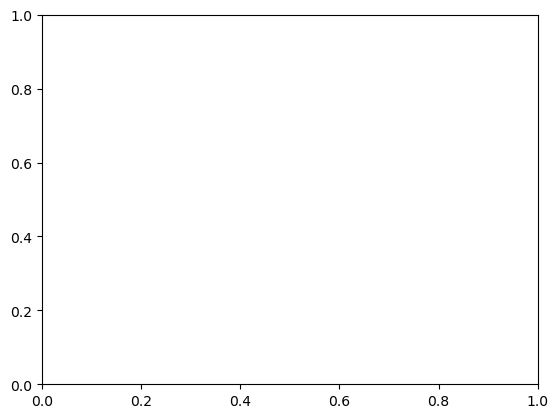

In [288]:
plt.plot(steps, r2_values_005,  label=r'R^2 curve for lxearning_rate = .05')
plt.plot(steps, r2_values_01, label=r'R^2 curve for learning_rate = 0.1')
plt.plot(steps, r2_values_001, label=r'R^2 curve for learning_rate = 0.01')
# plt.ylim(0.92,0.95)
# plt.xlim(1000,3500)
plt.legend(loc=4)

In [252]:

start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
# param_grid = {
#     'learning_rate': [1, 0.1, 0.01],
#     'subsample': [1.0, 0.8, 0.6]  # Different subsample sizes
# }

param_grid = {
    # 'learning_rate': [0.1, 0.05, 0.01],
    # 'subsample': [1.0, 0.8],
    # 'n_estimators': [100, 200],
    # 'max_depth': [3, 4],
    # 'min_samples_split': [2, 5],
    # 'min_samples_leaf': [1, 2]

    # 'learning_rate': [0.1, 0.05, 0.01, 0.001],
    # 'subsample': [1.0, 0.8, 0.7, 0.6, 0.5],
    'n_estimators': [100, 200, 300, 400, 500, 600],  # Add more values based on your computational resources
    # 'max_depth': [3, 4, 5],  # Adjust based on your dataset characteristics
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, min_samples_leaf=1,
                                     subsample=0.5, random_state=42)
# 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.5


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb_model.predict(X_test)

# Evaluate the model using R2
r2 = r2_score(y_test, y_pred)
print(f'R-squared on Test Data: {r2:.4f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Best Parameters: {'n_estimators': 600}
Best R-squared: 0.9378133530884766
R-squared on Test Data: 0.9390
Elapsed Time: 66.05 seconds


In [271]:

start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
# param_grid = {
#     'learning_rate': [1, 0.1, 0.01],
#     'subsample': [1.0, 0.8, 0.6]  # Different subsample sizes
# }

param_grid = {
    # 'learning_rate': [0.1, 0.05, 0.01],
    # 'subsample': [1.0, 0.8],
    # 'n_estimators': [100, 200],
    # 'max_depth': [3, 4],
    # 'min_samples_split': [2, 5],
    # 'min_samples_leaf': [1, 2]

    # 'learning_rate': [0.1, 0.05, 0.01, 0.001],
    # 'subsample': [1.0, 0.8, 0.7, 0.6, 0.5],
    'n_estimators': [4000, 5000],  # Add more values based on your computational resources
    # 'max_depth': [3, 4, 5],  # Adjust based on your dataset characteristics
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, min_samples_leaf=1,
                                     subsample=0.5, random_state=42)
# 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.5


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb_model.predict(X_test)

# Evaluate the model using R2
r2 = r2_score(y_test, y_pred)
print(f'R-squared on Test Data: {r2:.4f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Best Parameters: {'n_estimators': 4000}
Best R-squared: 0.937697741094804
R-squared on Test Data: 0.9407
Elapsed Time: 292.17 seconds


In [272]:

start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid
# param_grid = {
#     'learning_rate': [1, 0.1, 0.01],
#     'subsample': [1.0, 0.8, 0.6]  # Different subsample sizes
# }

param_grid = {
    # 'learning_rate': [0.1, 0.05, 0.01],
    # 'subsample': [1.0, 0.8],
    # 'n_estimators': [100, 200],
    # 'max_depth': [3, 4],
    # 'min_samples_split': [2, 5],
    # 'min_samples_leaf': [1, 2]

    # 'learning_rate': [0.1, 0.05, 0.01, 0.001],
    # 'subsample': [1.0, 0.8, 0.7, 0.6, 0.5],
    'n_estimators': [4000, 4100, 4200],  # Add more values based on your computational resources
    # 'max_depth': [3, 4, 5],  # Adjust based on your dataset characteristics
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4]
}

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=4, learning_rate=0.05, min_samples_leaf=1,
                                     subsample=0.5, random_state=42)
# 'learning_rate': 0.05, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300, 'subsample': 0.5


# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, scoring='r2', cv=5)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and their corresponding R2 score
print("Best Parameters:", grid_search.best_params_)
print("Best R-squared:", grid_search.best_score_)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Make predictions on the test data using the best model
y_pred = best_gb_model.predict(X_test)

# Evaluate the model using R2
r2 = r2_score(y_test, y_pred)
print(f'R-squared on Test Data: {r2:.4f}')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


Best Parameters: {'n_estimators': 4000}
Best R-squared: 0.937697741094804
R-squared on Test Data: 0.9407
Elapsed Time: 390.65 seconds


In [277]:
gbmr = GradientBoostingRegressor()

start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_estimators = 10100
gbmr.set_params(n_estimators=n_estimators, max_depth=4, learning_rate=0.05, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
train_r2 = []
test_r2  = []
steps = range(100,10100,1000)

gbmr.fit(X_train, y_train)
gen_train = gbmr.staged_predict(X_train)
gen_test  = gbmr.staged_predict(X_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2.append(r2_score(y_train, predicted_train))
           test_r2.append(r2_score(y_test, predicted_test))   

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Elapsed Time: 72.66 seconds


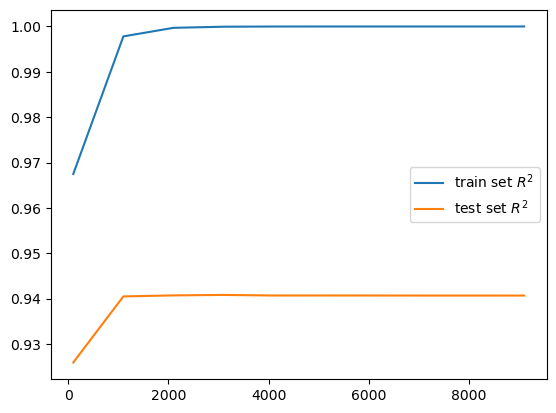

In [279]:
plt.plot(steps, train_r2, label='train set $R^2$')
plt.plot(steps, test_r2, label='test set $R^2$')
plt.legend(loc=7)

In [282]:
test_r2

[0.9259216171665153,
 0.9404874222179039,
 0.940712681987965,
 0.940813886453195,
 0.9406880448935926,
 0.9406955271021311,
 0.9406862962301175,
 0.9406797996272217,
 0.9406780348565491,
 0.9406746986281651]

In [284]:
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.


gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.1, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_a = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_a.append(r2)


In [283]:
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.


gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.05, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_b = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_b.append(r2)


In [285]:
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
steps = range(100, 10100, 1000) # 14100 would be find cap after flattening.


gbmr = GradientBoostingRegressor(n_estimators=10100, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
gbmr.fit(X_train, y_train)
gen = gbmr.staged_predict(X_test)
r2_values_c = []
for n, predicted_targets in enumerate(gen):
    if n not in steps:
        continue
    r2 = r2_score(y_test, predicted_targets)
    r2_values_c.append(r2)


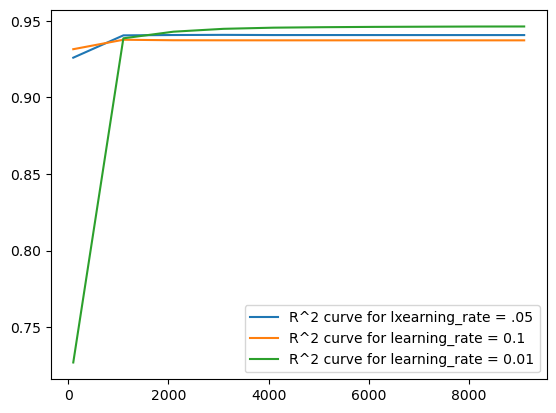

In [286]:
plt.plot(steps, r2_values_b,  label=r'R^2 curve for lxearning_rate = .05')
plt.plot(steps, r2_values_a, label=r'R^2 curve for learning_rate = 0.1')
plt.plot(steps, r2_values_c, label=r'R^2 curve for learning_rate = 0.01')
# plt.ylim(0.92,0.95)
# plt.xlim(1000,3500)
plt.legend(loc=4)

Elapsed Time: 73.60 seconds


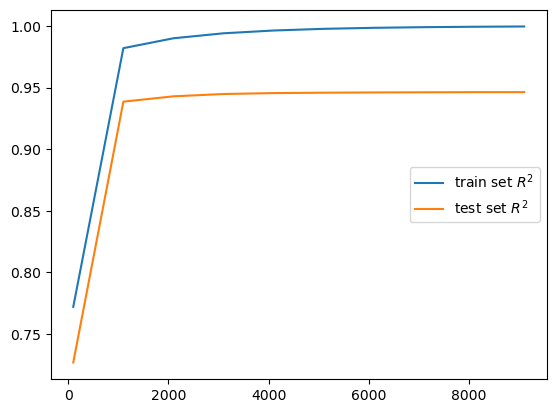

In [287]:
gbmr = GradientBoostingRegressor()

start_time = time.time()

# Separate features and target variable
X = df_with_dummies.drop('SalePrice', axis=1)
y = df_with_dummies['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_estimators = 10100
gbmr.set_params(n_estimators=n_estimators, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
train_r2 = []
test_r2  = []
steps = range(100,10100,1000)

gbmr.fit(X_train, y_train)
gen_train = gbmr.staged_predict(X_train)
gen_test  = gbmr.staged_predict(X_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2.append(r2_score(y_train, predicted_train))
           test_r2.append(r2_score(y_test, predicted_test))   

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
plt.plot(steps, train_r2, label='train set $R^2$')
plt.plot(steps, test_r2, label='test set $R^2$')
plt.legend(loc=7)

In [289]:
test_r2

[0.7269765034969846,
 0.9385620353913662,
 0.942884992021722,
 0.9447553309465374,
 0.9455113851004094,
 0.9458220290062198,
 0.9460225485031607,
 0.9461393639733652,
 0.9462502585617544,
 0.946286440682645]

# TAKE 2 WITHOUT DUMMIES

In [318]:
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = gb_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 365629013.61
R-squared: 0.9328


Elapsed Time: 62.56 seconds


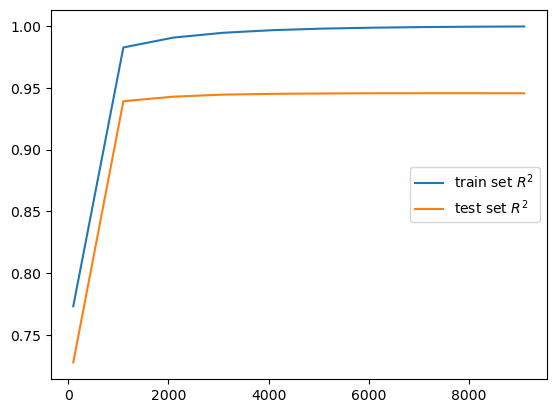

In [319]:
gbmr = GradientBoostingRegressor()

start_time = time.time()

# Separate features and target variable
X = df_numerical.drop('SalePrice', axis=1)
y = df_numerical['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_estimators = 10100
gbmr.set_params(n_estimators=n_estimators, max_depth=4, learning_rate=0.01, 
                min_samples_leaf=1, subsample=0.5, random_state=42)
train_r2 = []
test_r2  = []
steps = range(100,10100,1000)

gbmr.fit(X_train, y_train)
gen_train = gbmr.staged_predict(X_train)
gen_test  = gbmr.staged_predict(X_test)

for n in range(n_estimators):
           predicted_train = next(gen_train)
           predicted_test  = next(gen_test)
           if n not in steps: continue
           train_r2.append(r2_score(y_train, predicted_train))
           test_r2.append(r2_score(y_test, predicted_test))   

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")
plt.plot(steps, train_r2, label='train set $R^2$')
plt.plot(steps, test_r2, label='test set $R^2$')
plt.legend(loc=7)